## Importing Libraries

These are libraries that will be used throughout this part of the project

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import math
import os
import time
import warnings; warnings.simplefilter('ignore')
import qgrid
import statistics
import seaborn as sns
from scipy import stats

qgrid.enable()

from datetime import timedelta, datetime

## Importing Data

### Actual Precipitation Data

There are 5 Datasets that I will use in this section of the analysis. The first of these contains the actual Precipitation data. This data has been taken directly from NOAA. For the US data, there are 10 locations which are stored in a csv file. This data contains daily precipitation data for the 10 locations in question.

We will again need a function which will be used to split the name of the location from the .csv file

In [76]:
def split_name(filename):
    return filename.split('.csv')[0]

In [77]:
date_range = ['','']
date_range[0] = "01-12-2020"
date_range[1] = "31-03-2021"

We can read in this .csv file in order to place this data into a pandas dataframe which we can then analyse.

In [78]:
actual_df = pd.read_csv("american_data.csv")

As can be seen below, this DataFrame simply has the Date, Location and the Precipitation actual value that Met Eireann has provided for that location. While this is useful to compare all of the locations, I will also be using the individual location data in order to make comparisons

Need to set the actual_df index as a Date Time Index

In [79]:
# Renaming columns
actual_df = actual_df.rename(columns={"PRCP":"Precipitation","DATE":"Date","NAME":"Location"})

# Convert Date column to datetime
actual_df['Date'] = pd.to_datetime(actual_df['Date'],format="%d/%m/%Y")
actual_df['Date'] = pd.DatetimeIndex(actual_df['Date']).tz_localize(None)

# We will then sort the columns and set index
actual_df = actual_df.sort_values(by=['Date','Location'])
actual_df = actual_df.set_index('Date')

# We can also drop columns that we dont need
actual_df = actual_df[['Location','Precipitation']]

In [80]:
actual_df

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [81]:
actual_df['Precipitation'].sum()

2691.1

We also need to create a dictionary which we can use to reference the locations in the dataframe

In [82]:
location_dict = {
    'Salt Lake City':0,
    'Chicago':1,
    'Houston':2,
    'New York':3,
    'Los Angeles':4,
    'Oklahoma':5,
    'Seattle':6,
    'Nashville':7,
    'Jacksonville':8,
    'Philadelphia':9
}

In [83]:
def reverse_dictionary(key):
    return list(location_dict.keys())[list(location_dict.values()).index(key)]

We can split up the actual data in the same way as we do with the forecast data in order to make them more comparable

In [84]:
# Collection to store data for each location
actual_data = {}

for location in location_dict.values():
    actual_data[location] = actual_df[actual_df['Location'] == reverse_dictionary(location)]

In [85]:
for i in range(0,9):
    print(reverse_dictionary(i))
    print(actual_data[i]['Precipitation'].sum())

Salt Lake City
114.50000000000001
Chicago
223.79999999999995
Houston
277.4
New York
288.49999999999994
Los Angeles
124.6
Oklahoma
155.89999999999998
Seattle
475.9
Nashville
441.6
Jacksonville
212.49999999999997


### Forecast Precipitation Data

In addition to the Actual Data collected from NOAA, we have collected Forecast Data from 4 sources. In this section, I will import these .csv files in to DataFrames also.

The 4 Sources are as follows:
- NOAA
- YR
- World Weather Online
- OpenWeather

In [86]:
noaa_forecast = pd.read_csv('NOAA_forecast.csv')
yr_forecast = pd.read_csv('us_yr_forecast_data.csv')
wwo_forecast = pd.read_csv('wwo_forecast_data.csv')
ow_forecast = pd.read_csv('us_ow_forecast_data.csv')

In order to analyse this data, a 2D array structure will allow us to do this efficiently. The first layer will contain all of the locations that we have collected data for. The next layer will contain the lead day precipitation data for each location. One issue with this at the moment is that we have some names which do not line up to what they are in the actual data. We can change that using the following code:

In [87]:
def change_names(dataframe):
    dataframe['Location'][dataframe['Location'] == 'NewYorkCity'] = 'New York'
    dataframe['Location'][dataframe['Location'] == 'OcklahomaCity'] = 'Oklahoma'
    dataframe['Location'][dataframe['Location'] == 'LosAngeles'] = 'Los Angeles'
    dataframe['Location'][dataframe['Location'] == 'SaltLakeCity'] = 'Salt Lake City'
    
    return dataframe

In [88]:
noaa_forecast = change_names(noaa_forecast)
yr_forecast = change_names(yr_forecast)
ow_forecast = change_names(ow_forecast)
wwo_forecast = change_names(wwo_forecast)

The next step will be to split up the dataset into the 10 locations that we have downloaded data for.

In [89]:
# lead_day_collection = {}

# for lead_day in range(0,5):
#     lead_day_collection[lead_day] = pd.DataFrame(columns=["Location","Date of Prediction","Date","Precipitation"])

In [90]:
def split_into_days(df,date_range):
    # Create an empty array 
    dataframe_collection = {}
    
    for lead_day in range(0,5):
        dataframe_collection[lead_day] = pd.DataFrame(columns=["Location","Date of Prediction","Date","Precipitation"])
        
    # Convert Date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = pd.DatetimeIndex(df['Date']).tz_localize(None)
    
    # We take only the forecast data which is in the given date range
    df = df.loc[df['Date'] >= date_range[0]]
    df = df.loc[df['Date'] <= date_range[1]]
        
    for hour in df['Date'].unique():
            temp_df = df[df['Date'] == hour]
            
            for day in temp_df['Date of Prediction']:
                current = temp_df[temp_df['Date of Prediction'] == day]
                date = pd.to_datetime(str(current['Date'].values[0]).split("T")[0],format="%Y-%m-%d")
                date_of_prediction = pd.to_datetime(str(day).split(" ")[0],format="%Y-%m-%d")
                
                difference = (date-date_of_prediction).days
                
                try:
                    dataframe_collection[difference] = dataframe_collection[difference].append(current)
                except Exception as e:
                    print("NOAA data " + str(difference ) + " days in advance")
        
    return dataframe_collection

In [91]:
yr_data = {}
ow_data = {}
wwo_data = {}
noaa_data = {}

for location in location_dict.values():
    yr_data[location] = split_into_days(yr_forecast[yr_forecast['Location'] == reverse_dictionary(location)],date_range)
    ow_data[location] = split_into_days(ow_forecast[ow_forecast['Location'] == reverse_dictionary(location)],date_range)
    wwo_data[location] = split_into_days(wwo_forecast[wwo_forecast['Location'] == reverse_dictionary(location)],date_range)
    noaa_data[location] = split_into_days(noaa_forecast[noaa_forecast['Location'] == reverse_dictionary(location)],date_range)

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in 

NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in 

NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in 

NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in 

NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in 

NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in 

NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data -1 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data -1 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data -1 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data -1 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data -1 days in advance
NOAA data 7 days in advance
NOAA data 6 day

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in 

NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in 

NOAA data 7 days in advance
NOAA data 7 days in advance
NOAA data 7 days in advance
NOAA data 7 days in advance
NOAA data 7 days in advance
NOAA data 7 days in advance
NOAA data 7 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in 

NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 6 days in 

NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in 

NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in 

NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in 

NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in 

NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 8 days in 

NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 8 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in 

NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in 

NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in 

NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in 

NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data -1 days in advance
NOAA data -1 days in advance
NOAA data -1 days in advance
NOAA data -1 days in advance
NOAA data -1 days in advance
NOAA data -1 days in advance
NOAA data -1 days in advance
NOAA data -1 days in advance
NOAA data -1 days in advance
NOAA data -1 days in advance
NOAA data -1 days in advance
NOAA data -1 days in advance
NOAA data -1 days in advance
NOAA data -1 days in advance
NOAA data -1 days in advance
NOAA data -1 days in advance
NOAA data -1 days in advance
NOA

NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in 

NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in 

NOAA data -1 days in advance
NOAA data 5 days in advance
NOAA data -1 days in advance
NOAA data 5 days in advance
NOAA data -1 days in advance
NOAA data 5 days in advance
NOAA data -1 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days

NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in 

NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in 

NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in 

NOAA data -1 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data -1 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data -1 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data -1 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data -1 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data -1 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data -1 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 d

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in 

NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 7 days in advance
NOAA data 7 days in advance
NOAA data 7 days in advance
NOAA data 7 days in advance
NOAA data 7 days in advance
NOAA data 7 days in advance
NOAA data 7 days in advance
NOAA data 7 days in advance
NOAA data 7 days in advance
NOAA data 7 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in 

NOAA data -1 days in advance
NOAA data -1 days in advance
NOAA data -1 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in 

NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data -1 days in advance
NOAA data 6 days in advance
NOAA data -1 days in advance
NOAA data 6 days in advance
NOAA data -1 days in advance
NOAA data 6 days in advance
NOAA data -1 days in advance
NOAA data 6 days in advance
NOAA data -1 days in advance
NOAA data 6 days in advance
NOAA data -1 days in advance
NOAA data 6 days in advance
NOAA data -1 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 d

NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in 

NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in 

NOAA data 7 days in advance
NOAA data 7 days in advance
NOAA data 7 days in advance
NOAA data 8 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in 

NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in 

NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in 

NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 6 days in advance
NOAA data 5 days in 

NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in 

NOAA data 8 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in advance
NOAA data 6 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in 

NOAA data -1 days in advance
NOAA data 7 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data -1 days in advance
NOAA data 8 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 8 days i

NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in 

NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in 

NOAA data -1 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data -1 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data -1 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data -1 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 8 days in advance
NOAA data 7 days in advance
NOAA data 6 days

NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in 

NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 6 days in advance
NOAA data 5 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in advance
NOAA data 7 days in advance
NOAA data 6 days in 

We now need to change all of these to be in daily grain. We also need to change the index to a datetimeindex.

In [92]:
def hourly_to_daily(dataframe):
    for i in range(0,10):
        for j in range(0,5):
            dataframe[i][j]['Date'] = pd.to_datetime(dataframe[i][j]['Date'],format="%Y-%m-%d")
            dataframe[i][j] = dataframe[i][j].set_index('Date')
            dataframe[i][j] = dataframe[i][j].resample('1d').sum()
            
    return dataframe

In [93]:
yr_data = hourly_to_daily(yr_data)
ow_data = hourly_to_daily(ow_data)
wwo_data = hourly_to_daily(wwo_data)
noaa_data = hourly_to_daily(noaa_data)

The following is a function which will return two comparable datasets. It will only return date values that exist in both the observed and actual dataframes

In [94]:
def comparison(actual,forecast):
    # Take the unique date values that appear in the indexes of both of these columns
    actual_date_values = actual.index.unique()
    forecast_date_values = forecast.index.unique()
    
    # Calculate the intersection of these values
    inter = intersection(actual_date_values,forecast_date_values)
    
    output_actual = actual[actual.index.isin(inter)]
    output_forecast = forecast[forecast.index.isin(inter)]
    
    return output_actual,output_forecast

In [95]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

The following function creates a dataframe containing the difference between actual and forecast values for one Weather Forecasting Service

In [97]:
def actual_vs_predicted(actual,forecast,lead_day):
    output_df = pd.DataFrame(columns=["Location","Forecasted","Actual","Difference"])
    
    for i in location_dict.values():
#         print("Length of Actual" + str(len(actual[i])))
#         print("Length of Forecast" + str(len(forecast[i][lead_day])))
        actual[i],forecast[i][lead_day] = comparison(actual[i],forecast[i][lead_day])
#         print("-------------------------------")
#         print("Length of Actual" + str(len(actual[i])))
#         print("Length of Forecast" + str(len(forecast[i][lead_day])))
        print("")
        
        output_df = output_df.append({
            'Location':reverse_dictionary(i),
            'Forecasted':forecast[i][1]['Precipitation'].sum(),
            'Actual':actual[i]['Precipitation'].sum(),
            'Difference':(forecast[i][1]['Precipitation'].sum()-actual[i]['Precipitation'].mean())/actual[i]['Precipitation'].mean()
        },ignore_index=True)
    
    return output_df

In [98]:
ans = actual_vs_predicted(actual_data,yr_data,1)
ow = actual_vs_predicted(actual_data,ow_data,1)
wwo = actual_vs_predicted(actual_data,wwo_data,1)
noaa = actual_vs_predicted(actual_data,noaa_data,1)

Need to compare values from different services

In [99]:
actual_comp = pd.DataFrame(columns=['actual','noaa','yr','ow','wwo',])

actual_comp['actual'] = ow['Actual']
actual_comp['yr'] = ans['Forecasted']
actual_comp['noaa'] = noaa['Forecasted']
actual_comp['ow'] = ow['Forecasted']
actual_comp['wwo'] = wwo['Forecasted']

In [100]:
actual_comp

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

[Text(0, 0, 'Salt Lake City'),
 Text(1, 0, 'Chicago'),
 Text(2, 0, 'Houston'),
 Text(3, 0, 'New York'),
 Text(4, 0, 'Los Angeles'),
 Text(5, 0, 'Oklahoma'),
 Text(6, 0, 'Seattle'),
 Text(7, 0, 'Nashville'),
 Text(8, 0, 'Jacksonville'),
 Text(9, 0, 'Philadelphia')]

<Figure size 864x576 with 0 Axes>

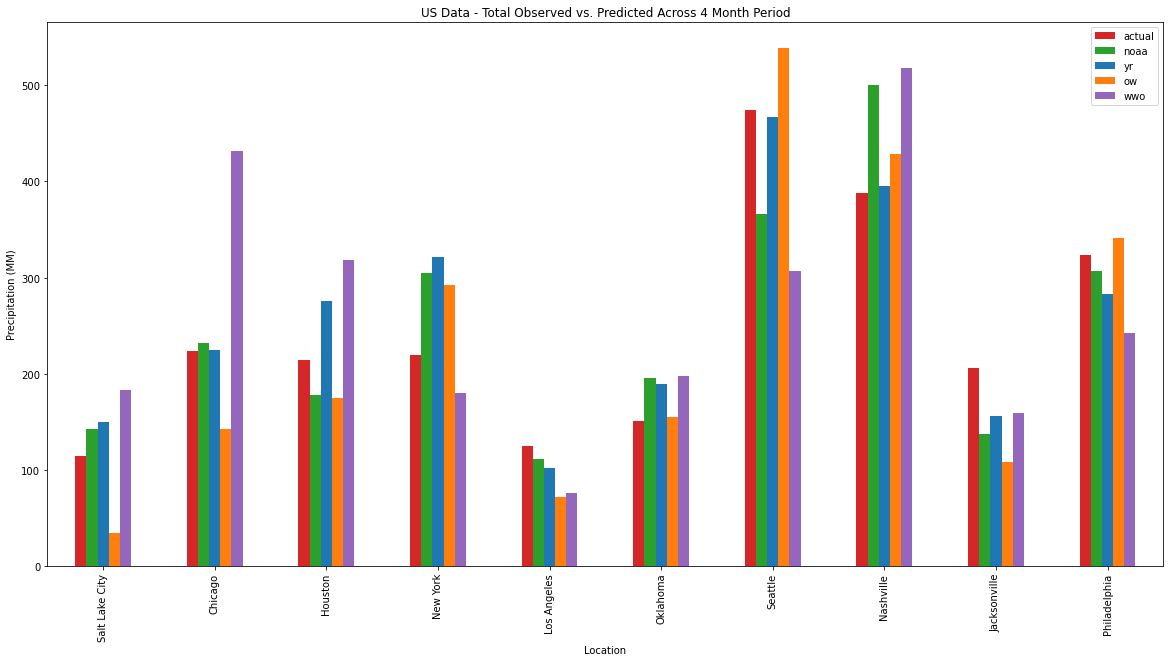

In [101]:
x_labels = ['Salt Lake City','Chicago','Houston','New York','Los Angeles','Oklahoma','Seattle','Nashville',
            'Jacksonville','Philadelphia']

#actual_comp.plot.bar(figsize=(20,10))
plt.figure(figsize=(12,8))
ax = actual_comp.plot.bar(figsize=(20,10),color=['tab:red','tab:green','tab:blue','tab:orange','tab:purple'])
ax.set_title("US Data - Total Observed vs. Predicted Across 4 Month Period")
ax.set_ylabel("Precipitation (MM)")
ax.set_xlabel("Location")
ax.set_xticklabels(x_labels)

Need to create a function that will show the daily values across a month:

In [102]:
def daily_actual_vs_forecasted(actual,forecast,date_range):
    # Get comparable datasets
    actual,forecast = comparison(actual,forecast)
    
    # Create a DataFrame and give it a title
    columns = ['Forecast','Actual','Difference']
    daily_df = pd.DataFrame(columns=columns)
    for i in range(0,len(actual)):
        date = actual.iloc[i].index
        daily_actual = actual['Precipitation'].iloc[i]
        daily_forecast = forecast['Precipitation'].iloc[i]
        daily_difference = daily_forecast-daily_actual
        
        daily_df = daily_df.append({'Forecast':float(daily_forecast),'Actual':float(daily_actual),
                                        'Difference':float(daily_difference)},ignore_index=True)
        
    return daily_df

### BOXPLOTS

Need to create boxplots for the overall american data for each service. As these are currently spread across locations, we will have to merge these into one large dataframe

In [103]:
# Write now we store noaa data in noaa_data[location][lead_day]

# We would like the data in the format noaa_all_locations[lead_day]

def location_to_sum(collection):
    # Figure out the number of lead days
    lead_days = len(collection[0])
    
    # Create an output array of dataframes
    output_collection = []

    for i in range(0,lead_days):
        output_collection.append(pd.DataFrame()) 
    
    # loop through each lead day
    for lead_day in range(0,lead_days):
        # Loop through each location
        for location in range(0,len(collection)):
            output_collection[lead_day] = output_collection[lead_day].append(collection[location][lead_day])
            print(collection[location][lead_day])
            
    return output_collection

In [104]:
noaa_all = location_to_sum(noaa_data)
yr_all = location_to_sum(yr_data)
wwo_all = location_to_sum(wwo_data)
ow_all = location_to_sum(ow_data)

            Precipitation  Probability
Date                                  
2020-12-08          0.000          6.0
2020-12-09          0.000         48.0
2020-12-10          0.000         54.0
2020-12-11          0.508        180.0
2020-12-12          3.048        979.0
...                   ...          ...
2021-03-26          3.556        993.0
2021-03-27          0.000          0.0
2021-03-28          0.000          0.0
2021-03-29          0.508        450.0
2021-03-30          0.000        114.0

[113 rows x 2 columns]
            Precipitation  Probability
Date                                  
2020-12-08          0.000          6.0
2020-12-09          0.000         23.0
2020-12-10          0.000        456.0
2020-12-11          4.318         36.0
2020-12-12         28.956       1636.0
...                   ...          ...
2021-03-26          6.604       1487.0
2021-03-27          0.000          0.0
2021-03-28          0.000          0.0
2021-03-29          0.000        366.0
2

[112 rows x 2 columns]
            Precipitation  Number
Date                             
2020-12-09            0.0   372.0
2020-12-10            0.0   588.0
2020-12-11            4.6   588.0
2020-12-12            1.9   588.0
2020-12-13           20.6   588.0
...                   ...     ...
2021-03-23            5.9   564.0
2021-03-24            0.6   492.0
2021-03-25            0.5   588.0
2021-03-26            0.0   588.0
2021-03-28            0.0     0.0

[105 rows x 2 columns]
            Precipitation  Number
Date                             
2020-12-09            1.1   372.0
2020-12-10            0.0   588.0
2020-12-11            0.0   588.0
2020-12-12            0.4   588.0
2020-12-13            1.5   588.0
...                   ...     ...
2021-03-26            5.4   588.0
2021-03-27            0.0   588.0
2021-03-28            0.0     0.0
2021-03-29            0.0     0.0
2021-03-30            0.0   612.0

[109 rows x 2 columns]
            Precipitation  Number
Date       

[112 rows x 3 columns]
            Precipitation  Chance of Rain  Chance of Snow
Date                                                     
2020-12-10       0.000000             0.0             0.0
2020-12-11       0.000000             0.0             0.0
2020-12-12       1.000000           757.0             0.0
2020-12-13       7.566667          1143.0           168.0
2020-12-14       0.000000             0.0             0.0
...                   ...             ...             ...
2021-03-27       0.000000             0.0             0.0
2021-03-28       0.000000             0.0             0.0
2021-03-29       0.000000             0.0             0.0
2021-03-30       0.000000             0.0             0.0
2021-03-31       0.000000             0.0             0.0

[112 rows x 3 columns]
            Precipitation  Chance of Rain  Chance of Snow
Date                                                     
2020-12-10       0.000000             0.0             0.0
2020-12-11       0.000000

### DIFFERENCE BOXPLOT

return data for each of the ten locations for one service

In [105]:
def return_data(dataframe,lead_day):
    output = pd.DataFrame(columns =['Location','Difference'])
    
    for j in range(0,10):
        temp = daily_actual_vs_forecasted(actual_data[j],dataframe[j][lead_day],lead_day)
        
        for i in range(0,len(temp)):
            output = output.append({'Location':reverse_dictionary(j),'Difference':float(temp.iloc[i]['Difference'])},ignore_index=True)
    
    return output

In [106]:
data = return_data(noaa_data,3)

In [107]:
data

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### Reducing Noise

In [108]:
def reduce_outliers(data):   
    print(len(data))
    output = pd.DataFrame()
    
    for location in data['Location'].unique():
        
        temp = data[data['Location'] == location]
        temp = temp.dropna()
        temp = temp[(np.abs(stats.zscore(temp['Difference'])) < 1.5)]
        
        output = output.append(temp)
            
    return output

In [109]:
noaa_diff = reduce_outliers(return_data(noaa_data,2))
yr_diff = reduce_outliers(return_data(yr_data,2))
ow_diff = reduce_outliers(return_data(ow_data,2))
wwo_diff = reduce_outliers(return_data(wwo_data,2))


1072
1074
1074
1074


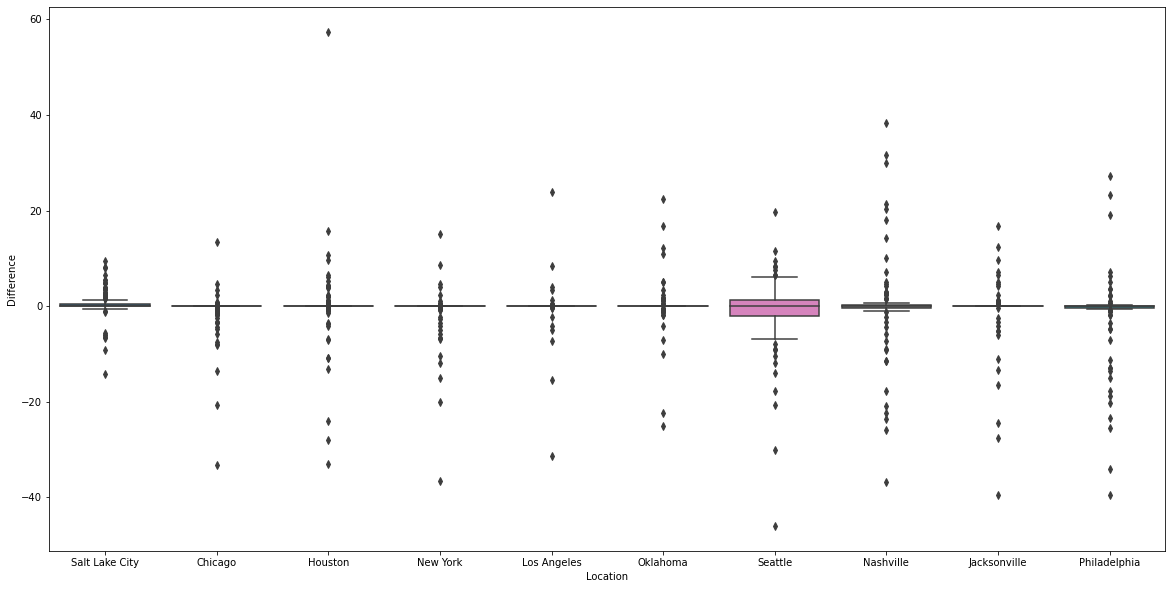

In [110]:
fig = plt.figure(1, figsize=(20,10))
ax = sns.boxplot(x='Location',y='Difference',data=data)

In [111]:
# Create a collection of dataframes to 
location_difference_df = {}
for i in range(0,10):
    location_difference_df[i] =pd.DataFrame()


index = 0
    
for location in wwo_diff['Location'].unique():
    temp_wwo = wwo_diff[wwo_diff['Location'] == location]
    temp_ow = ow_diff[ow_diff['Location'] == location]
    temp_noaa = noaa_diff[noaa_diff['Location'] == location]
    temp_yr = yr_diff[yr_diff['Location'] == location]
    
    temp_wwo['Service'] = 'WWO'
    temp_ow['Service'] = 'OW'
    temp_noaa['Service'] = 'NOAA'
    temp_yr['Service'] = 'YR'
    
    location_difference_df[index] = location_difference_df[index].append(temp_wwo)
    location_difference_df[index] = location_difference_df[index].append(temp_ow)
    location_difference_df[index] = location_difference_df[index].append(temp_noaa)
    location_difference_df[index] = location_difference_df[index].append(temp_yr)
    


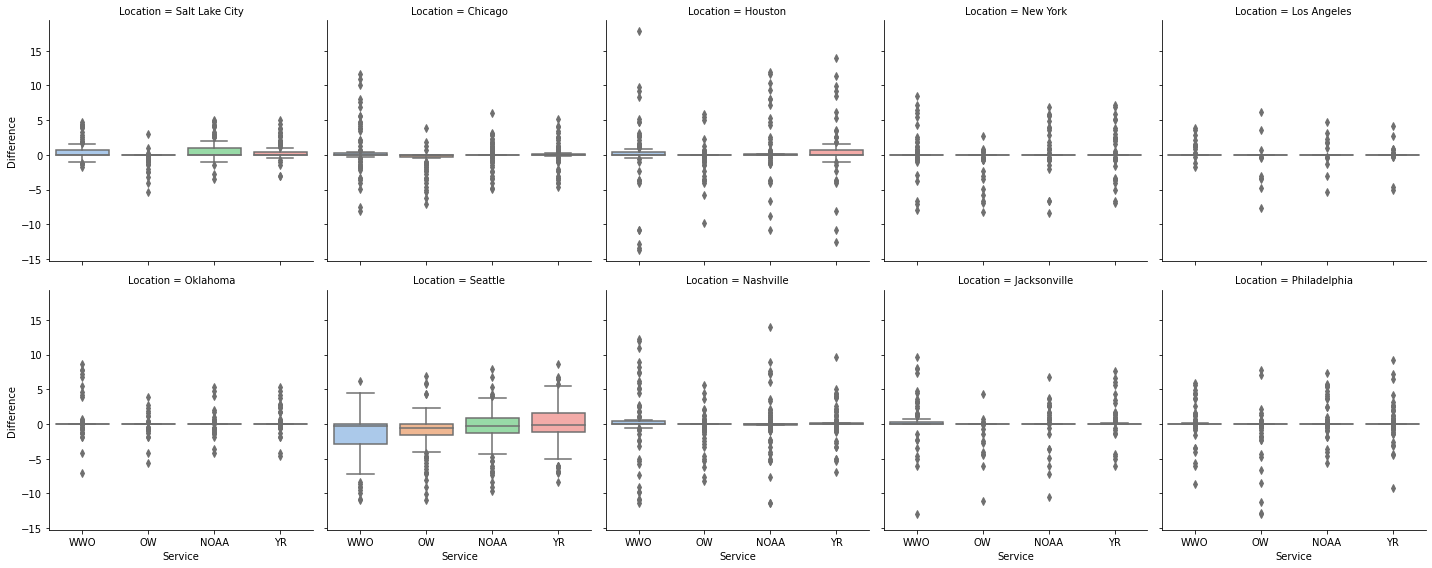

In [112]:
g = sns.FacetGrid(location_difference_df[0], col="Location", col_wrap=5, height=4,margin_titles = True,legend_out=True)
g.map(sns.boxplot, "Service", "Difference",palette='pastel')

In [113]:
def return_data_without_0vals(dataframe,lead_day):
    output = pd.DataFrame(columns =['Location','Difference'])
    
    for j in range(0,10):
        current = dataframe[j][lead_day]
        current = dataframe[j][lead_day][current['Precipitation'] != 0.0]
        temp = daily_actual_vs_forecasted(actual_data[j],current,lead_day)
        
        for i in range(0,len(temp)):
            output = output.append({'Location':reverse_dictionary(j),'Difference':float(temp.iloc[i]['Difference'])},ignore_index=True)
    
    return output

In [114]:
noaa_diff1 = reduce_outliers(return_data_without_0vals(noaa_data,1))
yr_diff1 = reduce_outliers(return_data_without_0vals(yr_data,1))
ow_diff1 = reduce_outliers(return_data_without_0vals(ow_data,1))
wwo_diff1 = reduce_outliers(return_data_without_0vals(wwo_data,1))

397
449
306
467


In [115]:
# Create a collection of dataframes to 
location_difference_df1 = {}
for i in range(0,10):
    location_difference_df1[i] =pd.DataFrame()


index = 0
    
for location in wwo_diff1['Location'].unique():
    temp_wwo1 = wwo_diff1[wwo_diff1['Location'] == location]
    temp_ow1= ow_diff1[ow_diff1['Location'] == location]
    temp_noaa1 = noaa_diff1[noaa_diff1['Location'] == location]
    temp_yr1 = yr_diff1[yr_diff1['Location'] == location]
    
    temp_wwo1['Service'] = 'WWO'
    temp_ow1['Service'] = 'OW'
    temp_noaa1['Service'] = 'NOAA'
    temp_yr1['Service'] = 'YR'
    
    location_difference_df1[index] = location_difference_df1[index].append(temp_wwo1)
    location_difference_df1[index] = location_difference_df1[index].append(temp_ow1)
    location_difference_df1[index] = location_difference_df1[index].append(temp_noaa1)
    location_difference_df1[index] = location_difference_df1[index].append(temp_yr1)
    


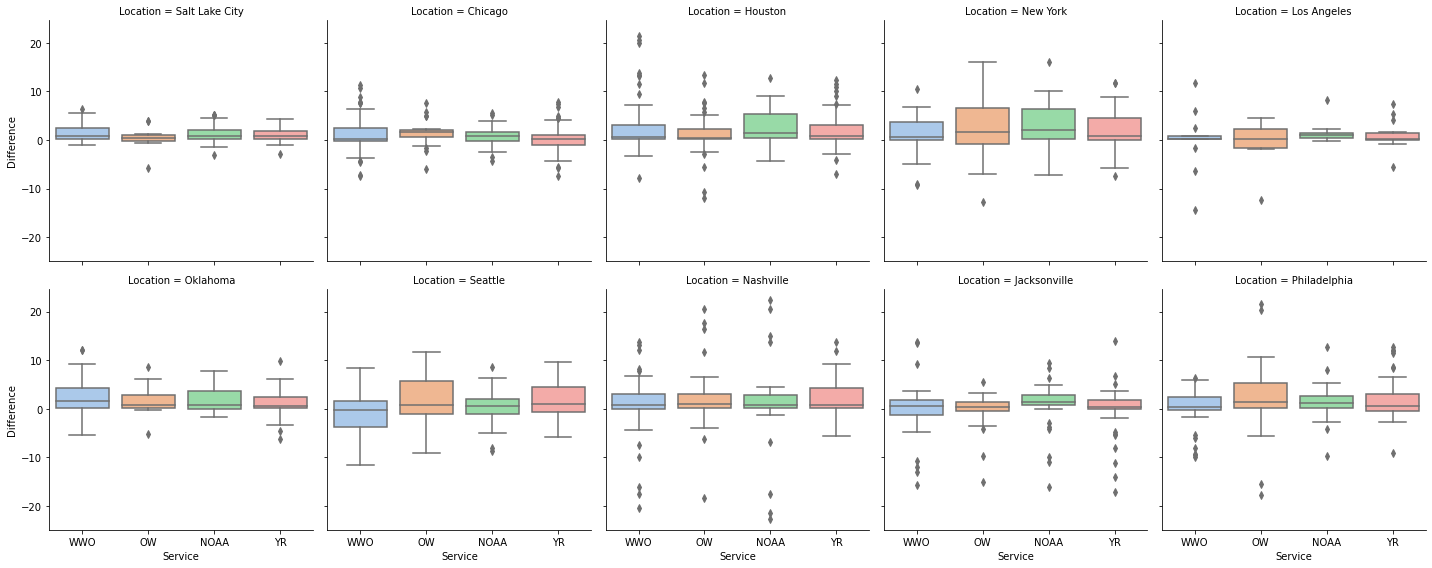

In [116]:
g = sns.FacetGrid(location_difference_df1[0], col="Location", col_wrap=5, height=4,margin_titles = True,legend_out=True)
g.map(sns.boxplot, "Service", "Difference",palette='pastel')

# Root Mean Squared Error

In [117]:
def root_mean_squared(data):
    
    sum_ = 0
    
    for i in range(0,len(data)):
        sum_ = sum_ + (data['Difference'].iloc[i]**2)
        
    
    
    return math.sqrt(sum_/len(data))

In [118]:
rmse_df = pd.DataFrame(columns=['Service', 'RMSE'])

rmse_df = rmse_df.append({'Service':'YR','RMSE':root_mean_squared(yr_diff)},ignore_index = True)
rmse_df = rmse_df.append({'Service':'NOAA','RMSE':root_mean_squared(noaa_diff)},ignore_index = True)
rmse_df = rmse_df.append({'Service':'OW','RMSE':root_mean_squared(ow_diff)},ignore_index = True)
rmse_df = rmse_df.append({'Service':'WWO','RMSE':root_mean_squared(wwo_diff)},ignore_index = True)

Text(0.5, 1.0, 'US Data - Root Mean Squared Error')

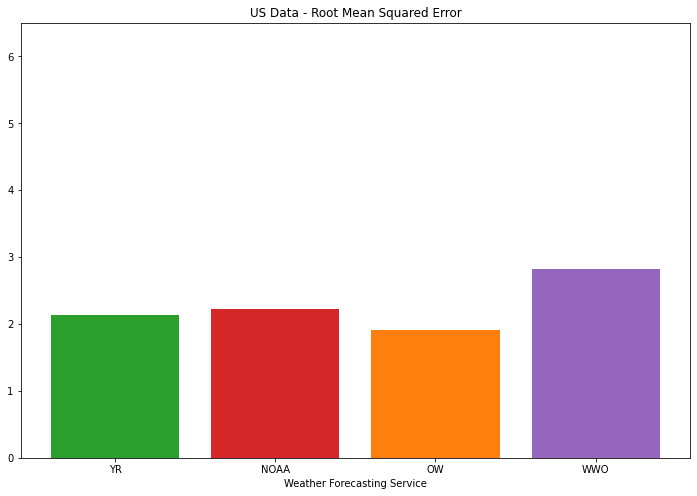

In [119]:
fig, ax = plt.subplots(figsize=(12,8))
test = ax.bar(rmse_df['Service'],rmse_df['RMSE'],color=['tab:green','tab:red','tab:orange','tab:purple'])
ax.set_ylim(0,6.5)
ax.set_xlabel('Weather Forecasting Service')
ax.set_title("US Data - Root Mean Squared Error")

In [120]:
len(actual_df)

1184

In [121]:
len(actual_df[actual_df['Precipitation'] == 0.0])

795

In [122]:
795/1184

0.6714527027027027

In [123]:
seattle =actual_df[actual_df['Location'] == 'Seattle']

In [124]:
len(seattle[seattle['Precipitation'] == 0.0])

27

In [125]:
len(seattle)

119

In [ ]:
location_difference_df2 = pd.DataFrame()
    
for i in range(1,3):
    noaa_diff2 = reduce_outliers(return_data_without_0vals(noaa_data,i))
    yr_diff2 = reduce_outliers(return_data_without_0vals(yr_data,i))
    ow_diff2 = reduce_outliers(return_data_without_0vals(ow_data,i))
    wwo_diff2 = reduce_outliers(return_data_without_0vals(wwo_data,i))
    
    temp_wwo1 = wwo_diff2
    temp_ow1= ow_diff2
    temp_noaa1 = noaa_diff2
    temp_yr1 = yr_diff2
    
    temp_wwo1['Service'] = 'WWO'
    temp_ow1['Service'] = 'OW'
    temp_noaa1['Service'] = 'NOAA'
    temp_yr1['Service'] = 'YR'
    
    temp_wwo1['Lead Day'] = i
    temp_ow1['Lead Day'] = i
    temp_noaa1['Lead Day'] = i
    temp_yr1['Lead Day'] = i
    
    location_difference_df2 = location_difference_df2.append(temp_wwo1)
    location_difference_df2 = location_difference_df2.append(temp_ow1)
    location_difference_df2 = location_difference_df2.append(temp_noaa1)
    location_difference_df2 = location_difference_df2.append(temp_yr1)
    


397
449
306
467
373


In [ ]:
len(location_difference_df2['Service'].unique())

In [ ]:
g = sns.FacetGrid(location_difference_df2, col="Lead Day", col_wrap=3, height=8,margin_titles = True,legend_out=True)
g.map(sns.boxplot, "Service", "Difference",palette='pastel')